### CNN-LSTM_v3

- 파이썬 버전: 3.8.18

### 1. Library 불러오기, SEED 설정, CUDA 사용

In [1]:
# 필요 라이브러리 import

# Pytorch
import torch
import torch.optim as optim
import torch.nn as nn

# Dataset 관련
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import sequence as sq # 사용자 정의 함수 불러오기

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns

# 하이퍼파라미터 튜닝
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import TimeSeriesSplit

# 운영체제 관련
import platform

'''
딥러닝 학습을 진행할 때, 가중치를 임의의 값으로 초기화하여 학습을 수행하는 데, 
실험을 동일하게 진행하기 위해서는 난수를 동일하게 생성해야 한다.
Pytorch에서 random seed를 고정하기 위해 manual_seed를 사용한다.
'''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 운영체제별 device 설정
os_name = platform.system()
if os_name == 'Windows':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"이 PC는 윈도우 운영 체제입니다: {device} is available")
elif os_name == 'Darwin':
    device = torch.device("mps" if torch.backends.mps.is_available else "cpu")
    print(f"이 PC는 맥(OS X) 운영 체제입니다: {device} is available")
else:
    print(f"이 PC는 다른 운영 체제입니다: {os_name}")


이 PC는 윈도우 운영 체제입니다: cuda:0 is available


### 2. 데이터 불러오기 및 전처리 (Binary, Scale, Tensor, train&valid&test split)

In [2]:
# 데이터 불러오기
file_path = '../../data/' # 경로 설정
#df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5_with_eemd.csv')
#df = df.iloc[:10000]
df['returns_next10m'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬

# sequence length를 기준으로 sequence 데이터 생성
seq_len = 20 # 20, 40, 80, 160, 320
X, y = sq.create_sequence(df, seq_len=seq_len) # 사용자 정의 함수
# Tensor화
X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)
print('Full Data Size:', X.size(), y.size())

# split (60% / 20% / 20%)
train_split = int((X.size(0)) * 0.6)
valid_split = int((X.size(0)) * 0.8)

X_train_seq = X[:train_split]
X_val_seq = X[train_split:valid_split]
X_test_seq = X[valid_split:]
y_train_seq = y[:train_split]
y_val_seq = y[train_split:valid_split]
y_test_seq = y[valid_split:]

print('Train Size:', X_train_seq.size(), y_train_seq.size())
print('Valid Size:', X_val_seq.size(), y_val_seq.size())
print('Test Size:', X_test_seq.size(), y_test_seq.size())


Full Data Size: torch.Size([111077, 20, 82]) torch.Size([111077, 1])
Train Size: torch.Size([66646, 20, 82]) torch.Size([66646, 1])
Valid Size: torch.Size([22215, 20, 82]) torch.Size([22215, 1])
Test Size: torch.Size([22216, 20, 82]) torch.Size([22216, 1])


In [3]:
# Dataset과 DataLoader를 이용해 배치 데이터로 만든다.
train = torch.utils.data.TensorDataset(X_train_seq, y_train_seq)
valid = torch.utils.data.TensorDataset(X_val_seq, y_val_seq)
test = torch.utils.data.TensorDataset(X_test_seq, y_test_seq)
batch_size = 128 # 32, 64, 128
train_loader =  torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


### 3. 모델 정의

In [6]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNNLSTMModel, self).__init__()
        
        # CNN 레이어
        '''
        in_channels = 일반적인 이미지와 같은 2D 데이터를 다룰 때는 특성 맵(channel)을 채널로 인식함.
        그러나 주식 시계열 데이터와 같은 1D 데이터의 경우 시퀀스 길이에 해당하는 차원이 채널로 간주됨.
        이에 따라 'in_channels'에는 시퀀스 길이를 입력해야 함.
        즉, 주식 시게열 데이터에서는 'in_channels'에는 시퀀스의 길이가 들어가야 올바르게 수행됨.
        '''
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # LSTM 레이어
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes) # Fully Connected 레이어
        
    def forward(self, x):
        # CNN 레이어 적용 (cnn takes input of shape (batch_size, channels, seq_len))
        x = x.permute(0, 2, 1)
        out = self.cnn(x)
        
        # LSTM 레이어 적용
        '''
        LSTM 레이어에 입력을 전달하고, LSTM의 출력과 은닉 상태를 받는 부분
        x.permute(0, 2, 1): 입력텐서 x의 차원을 변경. 일반적으로 LSTM 레이어는 시간 단계(seq_len)를 두 번쨰 차원으로 받지만,
        Conv1d 레이어의 출력은 시간 단계가 세번째 차원에 위치함. 따라서 permute를 통해 차원을 변경하여 LSTM 레이어에 올바른 형태의 입력을 제공
        여기서 0번째 차원은 배치 크기(batch_size)를 나타내며, 1번째 차원은 특성 수(num_features)를 나타냄. 마지막(2번째) 차원은 시간 단계(seq_len)를 나타냄
        self.lstm(x.permute(0, 2, 1)): 변경된 입력을 LSTM 레이어에 전달함. LSTM 입력으로 3D 텐서를 받으며,
        이 텐서는 배치 크기(batch_size), 시간 단계(seq_len),. 특성 수(num_features)의 형태를 가짐
        lstm_out, _: LSTM 레이어의 출력과 은닉 상태를 받음. 여기서 은닉 상태는 사용하지 않기 때문에 '_'로 무시. lstm_out은 LSTM 레이어의 출력으로, 각 시간 단계에
        해당하는 출력을 포함하는 3D 텐서임.
        '''
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm(out)
        
        # Fully Connected 레이어에 입력
        '''
        lstm_out[:, -1, :]: LSTM 레이어의 출력에서 마지막 시간 단계의 출력만 선택. 이는 시퀀스 예측을 위해 마지막 시간 단계의 정보만을 사용하고자 하는 것
        따라서 [:, -1, :]는 모든 배치와 모든 특성을 유지하면서 마지막 시간 단계의 출력을 선택함
        self.fc(lstm_out[:, -1, :]): 선택된 마지막 시간 단계의 출력을 Fully Connected(FC) 레이어에 입력함. FC 레이어는 입력된 LSTM 출력을 받아서 최종
        예측을 수행하는 역할을 함. 출력 크기는 1이며, 이는 주어진 입력에 대한 예측된 결과를 나타냄.
        '''
        out = self.fc(out[:, -1, :]) 
        return out

#model = CNNLSTMModel(input_size=77, hidden_size=64, num_layers=2, num_classes=1)
model = CNNLSTMModel(input_size=82, hidden_size=128, num_layers=2, num_classes=1)
model.to(device) # GPU 사용 시

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(82, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

### 4. 모델학습1: train, valid를 이용한 과적합 방지되는 epochs 찾기

In [5]:
# 학습1: valid를 이용한 과적합 방지 epochs 찾기

# 학습과 검증 손실을 저장할 리스트 초기화
train_losses = []
valid_losses = []

# # 손실 함수와 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss() # 시그모이드 활성화 함수가 내장되어 있음. 모델의 마지막 레이어에서 시그모이드 함수 별도 적용할 필요X
#criterion = nn.BCELoss() # 모델 출력이 시그모이드 활성화 함수를 거쳐 확률로 변환된 후의 값을 입력으로 받음. 입력 값은 0과 1사이의 확률 값.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

# 검증 데이터에 대한 모델 성능 평가 함수 정의
def evaluate(model, criterion, dataloader):
    model.eval()  # 모델을 평가 모드로 설정
    total_loss = 0.0
    
    with torch.no_grad():
        for batch_features, batch_targets in dataloader:
            # 배치를 GPU로 전송
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            
            # 모델에 대한 순전파 및 손실 계산
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            
            total_loss += loss.item()
    
    return total_loss / len(dataloader.dataset)  # 평균 손실 반환

# 학습 루프
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    total_loss = 0.0
    
    for batch_features, batch_targets in train_loader:
        # 배치를 GPU로 전송
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        # 모델에 대한 순전파 및 손실 계산
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)
        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # 에폭마다 학습 손실 기록
    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # 검증 데이터에 대한 손실 계산 및 기록
    valid_loss = evaluate(model, criterion, valid_loader)
    valid_losses.append(valid_loss)
    
    # 에폭마다 손실 출력
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Valid Loss: {valid_loss}')

# 손실 함수 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


RuntimeError: Given groups=1, weight of size [64, 77, 3], expected input[128, 82, 20] to have 77 channels, but got 82 channels instead

### 5. 모델학습2: 모델학습1에서 구한 epochs를 기준으로 train 데이터만 가지고 학습

In [7]:
@@@
'''
학습2: train data만 가지고 학습
이미 학습1 코드에서 모델이 학습을 수행하였으므로
학습2 코드 실행 전 재시작 -> 학습1 코드 실행 X -> 학습2 코드 실행(정해진 epochs만 학습)
'''

# 손실 함수와 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20 # train, valid loss를 ㄴ기준으로 과적합되기 전 epochs

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_features, batch_targets in train_loader:
        # 배치를 GPU로 전송
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        # 모델에 대한 순전파 및 손실 계산
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)
        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # 에폭마다 손실 출력
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')


SyntaxError: invalid syntax (1149775341.py, line 1)

Data Imbalance: Counter({1.0: 984, 0.0: 952})
Accuracy: 0.7149
Precision: 0.6782
Recall: 0.8354
F1 Score: 0.7486


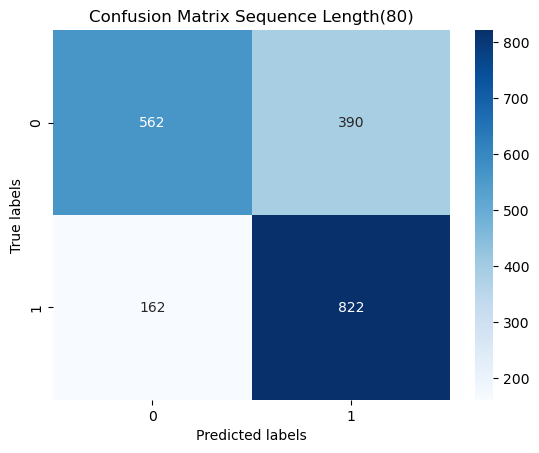

In [ ]:
# 테스트 데이터 예측
model.eval()  # 모델을 평가 모드로 설정
y_true = []
y_pred = []
with torch.no_grad():
    for x_batch, labels in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)

        # 로그 오즈를 확률로 변환
        probs = torch.sigmoid(outputs).squeeze()

        # 확률을 기준으로 0.5 이상이면 1, 미만이면 0으로 예측
        preds = torch.round(probs).cpu().numpy()
        y_true.extend(labels.squeeze().cpu().numpy())
        y_pred.extend(preds)

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 결과 출력
print(f'Data Imbalance: {Counter(y_true)}')
print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')

# 혼동 행렬 출력
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix Sequence Length({seq_len})')
plt.show()

### 6. 모델학습3: Optuna(with. Pruner) + CV 추가

In [ ]:
# 데이터 불러오기 / Optuna 용 -> valid 제거
file_path = '../../data/' # 경로 설정
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
#df = df.iloc[:20000]
df['returns_next10m'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬

# sequence length를 기준으로 sequence 데이터 생성
seq_len = 20 # 20, 40, 80, 160, 320
X, y = sq.create_sequence(df, seq_len=seq_len)
# Tensor화
X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)
print('Full Data Size:', X.size(), y.size())

# split (70% / 30%)
split = int((X.size(0)) * 0.7)

X_train_seq = X[:split]
X_test_seq = X[split:]
y_train_seq = y[:split]
y_test_seq = y[split:]

print('Train Size:', X_train_seq.size(), y_train_seq.size())
print('Test Size:', X_test_seq.size(), y_test_seq.size())


Full Data Size: torch.Size([7669, 20, 77]) torch.Size([7669, 1])
Train Size: torch.Size([5368, 20, 77]) torch.Size([5368, 1])
Test Size: torch.Size([2301, 20, 77]) torch.Size([2301, 1])


In [ ]:
# 학습 3: Optuna(with. Pruner) + CV 추가

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=5, gap=0)

    input_size = X.size(-1)
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    lr = trial.suggest_categorical('lr', [0.01, 0.001, 0.0001])
    num_epochs = 100

    total_loss = 0.0

    for train_idx, val_idx in tscv.split(X):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        train_dataset = TensorDataset(X_train_fold, y_train_fold)
        val_dataset = TensorDataset(X_val_fold, y_val_fold)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        model = CNNLSTMModel(input_size, hidden_size, num_layers, num_classes=1).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        model.train()
        for epoch in range(num_epochs):
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
            val_loss /= len(val_loader)

        total_loss += val_loss

        # Pruner를 위한 조기 중단 로직
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    avg_loss = total_loss / 5
    return avg_loss

# MedianPruner 초기화 및 Optuna 최적화 실행
pruner = MedianPruner()
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=50)

print('Best trial:', study.best_trial.params)
print("Best trial's value:", study.best_trial.value)


[I 2024-02-28 21:20:34,197] A new study created in memory with name: no-name-8852c764-fbe6-48e5-bb20-b0cdeaf9c5cd
c:\Users\com\anaconda3\Lib\site-packages\optuna\trial\_trial.py:499: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
[I 2024-02-28 21:22:12,960] Trial 0 finished with value: 0.6910429483652114 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 0.01}. Best is trial 0 with value: 0.6910429483652114.
[I 2024-02-28 21:23:53,114] Trial 1 finished with value: 2.064844066500664 and parameters: {'hidden_size': 64, 'num_layers': 3, 'lr': 0.001}. Best is trial 0 with value: 0.6910429483652114.
[I 2024-02-28 21:25:38,778] Trial 2 finished with value: 1.4596738010644912 and parameters: {'hidden_size': 96, 'num_layers': 5, 'lr': 0.001}. Best is trial 0 with value: 0.6910429483652114.


In [ ]:
# 최적의 하이퍼파라미터로 모델 평가
best_params = study.best_trial.params

input_size = X_test_seq.size(-1)

# 모델을 최적의 하이퍼파라미터로 초기화
best_model = CNNLSTMModel(input_size, best_params['hidden_size'], best_params['num_layers'], num_classes=1).to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'])

# 모델을 평가 모드로 전환
best_model.eval()

y_true = []
y_pred = []

# 검증 데이터로 평가
with torch.no_grad(): # 기울기 계산X -> 메모리 사용량, 속도 줄어듬
    val_loss = 0.0
    for x_batch, labels in test_loader:
        x_batch, labels = x_batch.to(device), labels.to(device)
        # 로그 오즈를 확률로 변환
        probs = torch.sigmoid(outputs).squeeze()
        # 확률을 기준으로 0.5 이상이면 1, 미만이면 0으로 예측
        preds = torch.round(probs).cpu().numpy()
        y_true.extend(labels.squeeze().cpu().numpy())
        y_pred.extend(preds)

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 결과 출력
print(f'Data Imbalance: {Counter(y_true)}')
print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')

# 혼동 행렬 출력
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix Sequence Length: {seq_len}(with. Optuna)')
plt.show()

SyntaxError: positional argument follows keyword argument (1180583119.py, line 7)

In [22]:
import pandas as pd

# 데이터 불러오기
file_path = '../../data/' # 경로 설정
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
df

,window_start,window_end,num_rows,lowest_return,highest_return,high_low_gap,trade_vol,volume_power,beginning_price,ending_price,...,ob_end_bs_14,ob_end_bias_0,ob_end_bias_1,ob_end_bias_4,ob_end_bidask_spread,ob_end_liq_0,ob_end_liq_1,ob_end_liq_4,highest_possible_return,del_idx
0,2022-12-16 21:05:30,2022-12-16 21:06:00,14,0.000000,0.000089,0.000089,1.468656,0.747351,22568000.0,22570000.0,...,1.467714,5.470422,10.649683,3.235541,2.0,0.001693,0.002198,0.002412,1.000000,0
1,2022-12-16 21:06:00,2022-12-16 21:06:30,10,0.000000,0.000089,0.000089,0.567585,0.027857,22568000.0,22570000.0,...,0.143039,4.224361,14.918538,3.856600,2.0,0.000531,0.001064,0.001471,1.000000,0
2,2022-12-16 21:06:30,2022-12-16 21:07:00,24,-0.000576,0.000044,0.000620,1.677093,0.146635,22570000.0,22570000.0,...,0.271898,17.677511,9.697905,1.106227,14.0,0.000449,0.000536,0.001821,0.999778,0
3,2022-12-16 21:07:00,2022-12-16 21:07:30,22,-0.000044,0.000443,0.000488,2.439677,0.751995,22557000.0,22567000.0,...,0.640898,95.630870,3.371113,1.367349,2.0,0.000416,0.000480,0.001422,0.999911,0
4,2022-12-16 21:07:30,2022-12-16 21:08:00,24,-0.000443,0.000000,0.000443,2.345821,-0.915608,22565000.0,22555000.0,...,0.081040,0.114815,0.828364,0.068175,10.0,0.000311,0.000560,0.003454,0.999911,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149554,2023-02-25 23:47:00,2023-02-25 23:47:30,12,0.000000,0.000033,0.000033,0.153247,0.802207,30507000.0,30508000.0,...,0.050066,0.000366,0.555042,0.257513,1.0,0.000637,0.000937,0.000995,1.000295,0
149555,2023-02-25 23:47:30,2023-02-25 23:48:00,20,-0.000033,0.000000,0.000033,0.879080,-0.505112,30509000.0,30509000.0,...,0.076681,2.503651,5.778803,4.708884,1.0,0.002924,0.003727,0.003737,1.000361,0
149556,2023-02-25 23:48:00,2023-02-25 23:48:30,10,-0.000033,0.000000,0.000033,0.412820,0.509523,30509000.0,30508000.0,...,2.110355,0.982967,2.550520,2.278613,1.0,0.002965,0.003754,0.003763,1.000393,0
149557,2023-02-25 23:48:30,2023-02-25 23:49:00,22,0.000000,0.000033,0.000033,2.141030,0.785751,30509000.0,30510000.0,...,1.824012,0.014928,0.000845,1.153614,4.0,0.000006,0.000094,0.000185,1.000295,0


In [23]:
# EEMD 인스턴스 생성 및 실행
eemd = EEMD()
eIMFs = eemd.eemd(df['returns_next10m'].values)

# IMF1부터 IMF5까지의 컬럼을 DataFrame에 추가
for i in range(min(5, eIMFs.shape[0])):  # eIMFs의 수가 5개 미만일 수 있으므로 최소값 사용
    df[f'IMF{i+1}'] = eIMFs[i, :]

df.tail()

,window_start,window_end,num_rows,lowest_return,highest_return,high_low_gap,trade_vol,volume_power,beginning_price,ending_price,...,ob_end_liq_0,ob_end_liq_1,ob_end_liq_4,highest_possible_return,del_idx,IMF1,IMF2,IMF3,IMF4,IMF5
149554,2023-02-25 23:47:00,2023-02-25 23:47:30,12,0.000000,0.000033,0.000033,0.153247,0.802207,30507000.0,30508000.0,...,0.000637,0.000937,0.000995,1.000295,0,-0.000005,0.000229,-0.000037,0.000033,-0.000170
149555,2023-02-25 23:47:30,2023-02-25 23:48:00,20,-0.000033,0.000000,0.000033,0.879080,-0.505112,30509000.0,30509000.0,...,0.002924,0.003727,0.003737,1.000361,0,-0.000026,0.000039,-0.000062,0.000025,-0.000161
149556,2023-02-25 23:48:00,2023-02-25 23:48:30,10,-0.000033,0.000000,0.000033,0.412820,0.509523,30509000.0,30508000.0,...,0.002965,0.003754,0.003763,1.000393,0,-0.000196,-0.000080,-0.000122,0.000018,-0.000149
149557,2023-02-25 23:48:30,2023-02-25 23:49:00,22,0.000000,0.000033,0.000033,2.141030,0.785751,30509000.0,30510000.0,...,0.000006,0.000094,0.000185,1.000295,0,0.000385,0.000008,-0.000159,0.000004,-0.000136
149558,2023-02-25 23:49:00,2023-02-25 23:49:30,5,0.000000,0.000197,0.000197,0.008701,1.000000,30513000.0,30519000.0,...,0.000269,0.000301,0.000511,1.000393,1,0.000149,-0.000004,-0.000086,-0.000025,-0.000125


In [29]:
#df.to_csv(file_path + "bitcoin_data_num_rows_gt_5_with_eemd.csv", index=False)

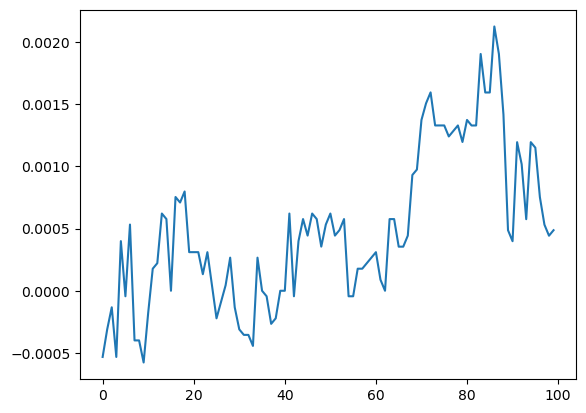

In [36]:
plt.plot(df['returns_next10m'].iloc[:100])

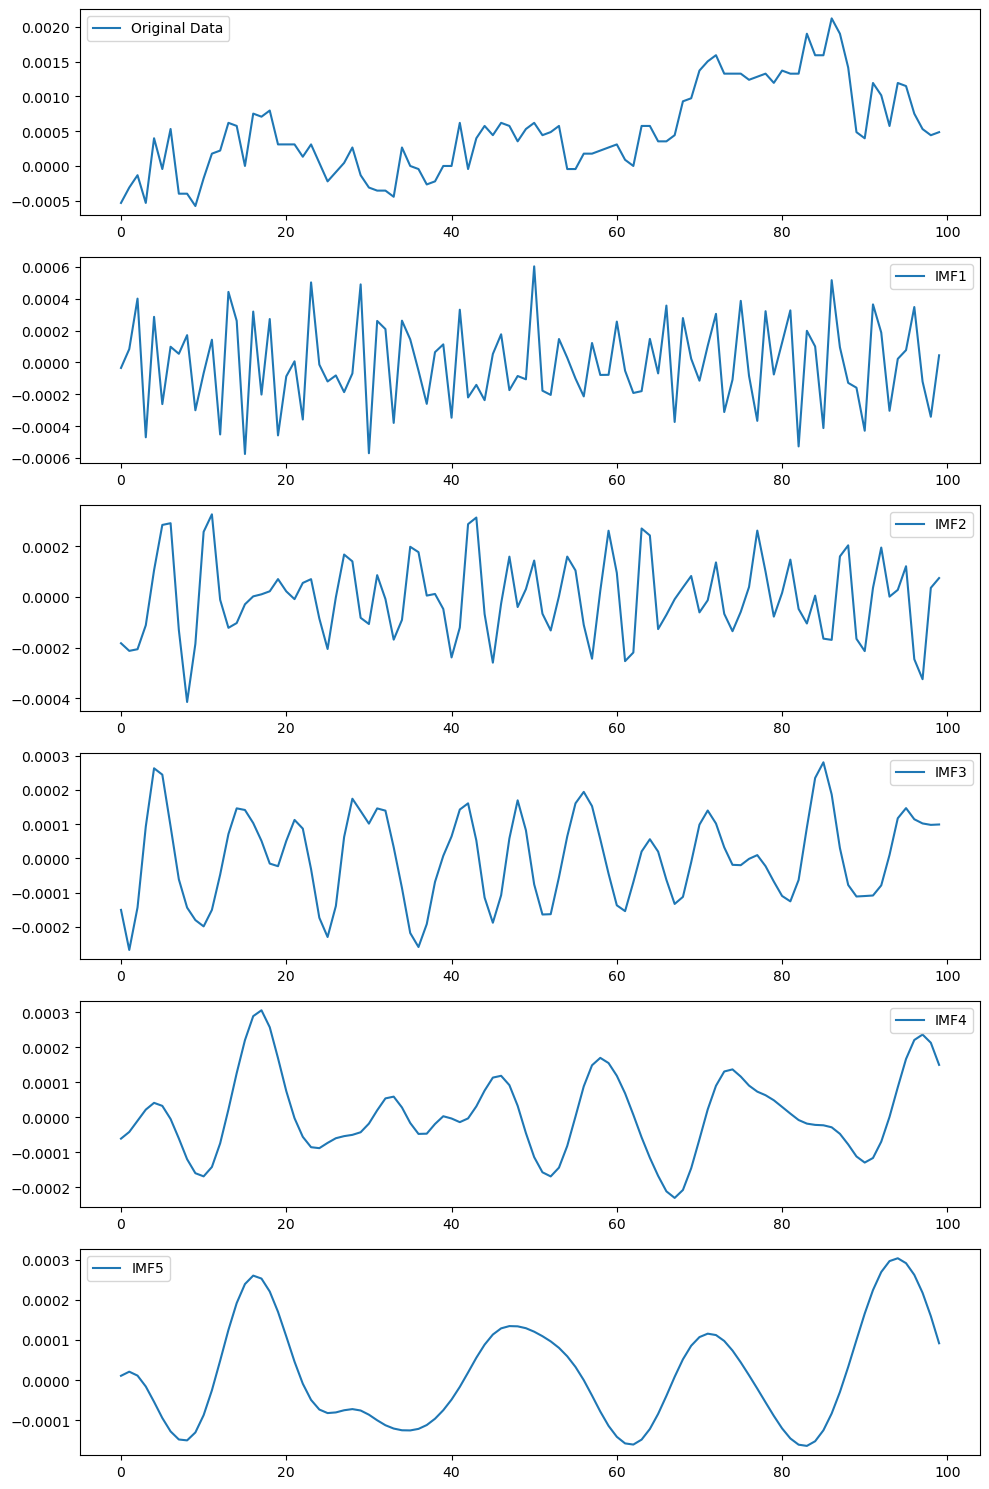

In [37]:
# 원본 데이터('returns_next10m')를 포함하여 각 IMF와 함께 시각화하기 위해 subplot 사용
plt.figure(figsize=(10, 15))

# 원본 데이터 시각화
plt.subplot(6, 1, 1)
plt.plot(df['returns_next10m'].iloc[:100], label='Original Data')
plt.legend()
plt.tight_layout()

# 각 IMF를 별도의 줄로 시각화
for i in range(1, 6):
    plt.subplot(6, 1, i+1)
    plt.plot(df[f'IMF{i}'].iloc[:100], label=f'IMF{i}')
    plt.legend()
    plt.tight_layout()

plt.show()


In [20]:
import pandas as pd
from PyEMD import EEMD
import numpy as np

# 실제 데이터를 가정한 예시입니다. 실제 사용 시에는 해당 데이터프레임에 실제 데이터를 사용해야 합니다.
data_example = [-0.000532, -0.000310, -0.000133, -0.000532, 0.000399] * 50  # 길이를 맞추기 위해 예시 데이터를 반복
df = pd.DataFrame({'returns_next10m': data_example})

# EEMD 인스턴스 생성 및 실행
eemd = EEMD()
eIMFs = eemd.eemd(df['returns_next10m'].values)

# IMF1부터 IMF5까지의 컬럼을 DataFrame에 추가
for i in range(min(5, eIMFs.shape[0])):  # eIMFs의 수가 5개 미만일 수 있으므로 최소값 사용
    df[f'IMF{i+1}'] = eIMFs[i, :]

# 생성된 컬럼들을 포함한 DataFrame의 상위 몇 행 출력
df.head()


,returns_next10m,IMF1,IMF2
0,-0.000532,-0.000195,-0.000346
1,-0.000310,0.000146,-0.000448
2,-0.000133,0.000275,-0.000405
3,-0.000532,-0.000355,-0.000179
4,0.000399,0.000421,-0.000020


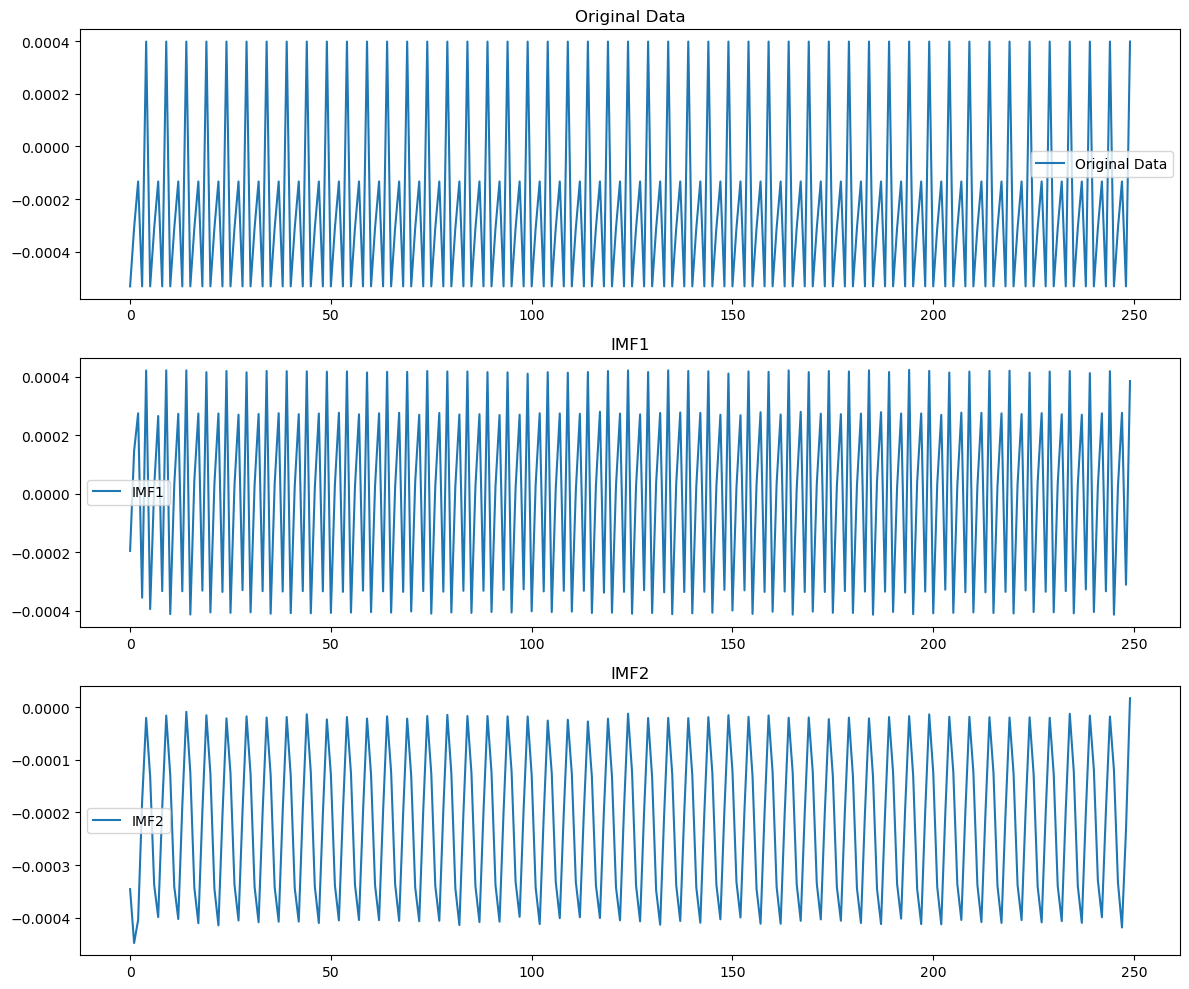

In [21]:
import matplotlib.pyplot as plt

# 데이터 프레임에서 생성된 IMF 컬럼들을 시각화
plt.figure(figsize=(12, 10))

# 원본 데이터 시각화
plt.subplot(min(6, eIMFs.shape[0]) + 1, 1, 1)
plt.plot(df.index, df['returns_next10m'], label='Original Data')
plt.title('Original Data')
plt.legend()

# IMF1부터 IMF5까지 시각화 (IMF의 수가 5개 미만일 경우에 대비)
for i in range(min(5, eIMFs.shape[0])):
    plt.subplot(min(6, eIMFs.shape[0]) + 1, 1, i+2)
    plt.plot(df.index, df[f'IMF{i+1}'], label=f'IMF{i+1}')
    plt.title(f'IMF{i+1}')
    plt.legend()

plt.tight_layout()
plt.show()


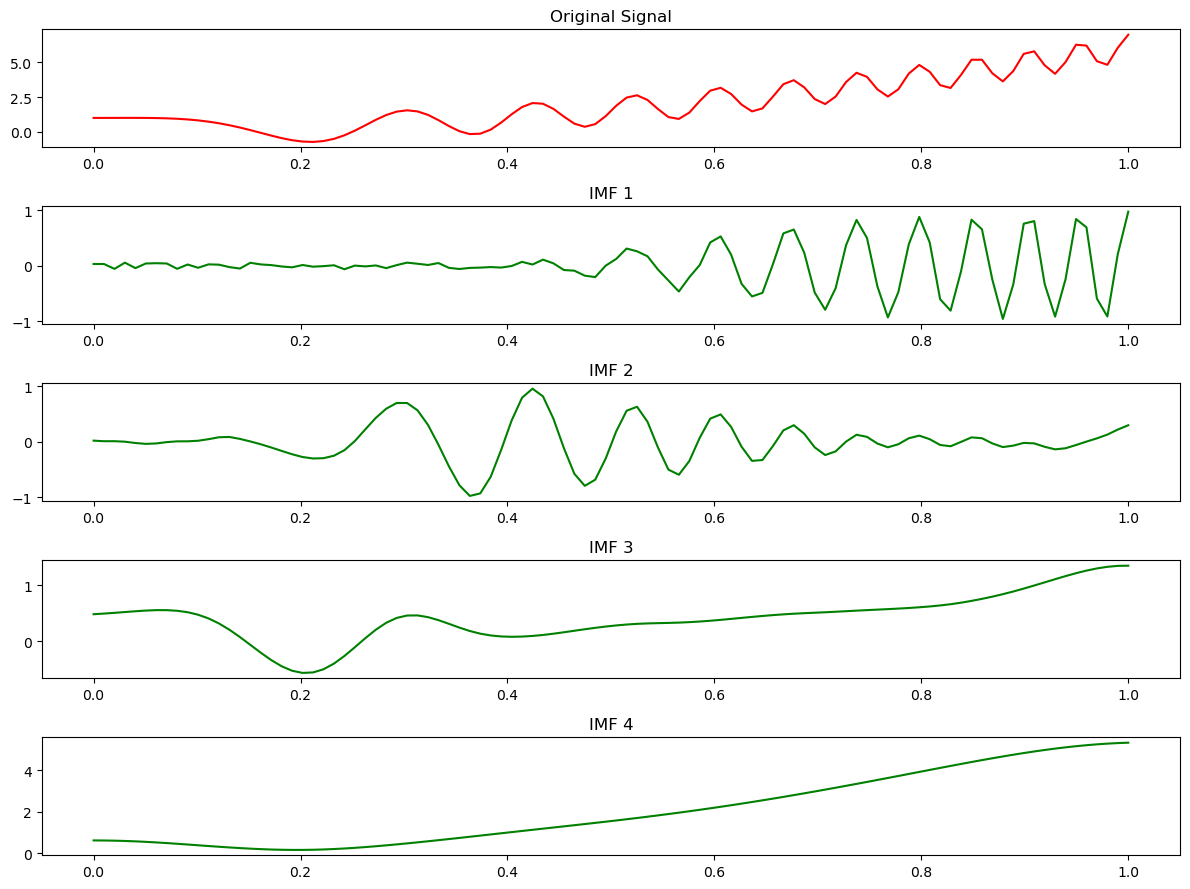

In [8]:
from PyEMD import EEMD
import numpy as np
import matplotlib.pyplot as plt

# 임의의 시계열 데이터 생성
t = np.linspace(0, 1, 100)
s = np.cos(11 * 2 * np.pi * t * t) + 6 * t * t

# EEMD 인스턴스 생성 및 실행
eemd = EEMD()
eIMFs = eemd(s)

# 결과 시각화
plt.figure(figsize=(12, 9))
plt.subplot(len(eIMFs) + 1, 1, 1)
plt.plot(t, s, 'r')
plt.title("Original Signal")

for i, imf in enumerate(eIMFs):
    plt.subplot(len(eIMFs) + 1, 1, i + 2)
    plt.plot(t, imf, 'g')
    plt.title("IMF {}".format(i + 1))

plt.tight_layout()
plt.show()
